In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import warnings
warnings.simplefilter("ignore", UserWarning)

from loguru import logger
import argparse
import yaml

import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,50))
import mmcv
import numpy as np

import rasterio

import sys
sys.path.append("/ViT-Adapter/segmentation")
import importlib

# make changes to example.py file

import mmcv_custom   # noqa: F401,F403
import mmseg_custom   # noqa: F401,F403
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmcv.runner import load_checkpoint
from mmseg.core import get_classes
import cv2
import os.path as osp
import torch
import time


In [2]:
config = "/proj-soils/scripts/heigvd/model/mask2former_beit_adapter_large_512_60k_proj-soils.py"
checkpoint = "/proj-soils/data/inference_heigvd/best_mIoU_iter_32000.pth"
source_folder = "/proj-soils/data/scratch_test_rgb/countryside"
target_folder = "/proj-soils/data/inference_heigvd/logits"
stride = 512
side_length = [12288,12660]
device = "cuda:0"
palette = None

config = "/proj-soils/scripts/heigvd/model/mask2former_beit_adapter_large_512_160k_proj-soils_12class_multiscale.py"
checkpoint = "/proj-soils/data/data_packages/data_inference-and-training/model_weights/heig-vd_finetuned/mixed_best_mIoU_iter_145320.pth"
source_folder = "/proj-soils/data_vm_bis/aoi_basel_clean/2020/subtiles/"
target_folder = "/proj-soils/data_vm_bis/aoi_basel_clean/2020/opt3/"
stride = 512
side_length = [512, 512]
device = "cuda:0"
palette = None

In [3]:
# Load the configuration file and initialize the segmentation model
config_mmcv = mmcv.Config.fromfile(config)

In [4]:
model = init_segmentor(config_mmcv, checkpoint=None, device=device)
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')

load checkpoint from local path: /proj-soils/data/inference_heigvd/best_mIoU_iter_32000.pth


In [5]:
# Set the classes based on the checkpoint metadata or the provided palette
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = get_classes(PALETTE)

In [6]:
model.CLASSES

('background',
 'batiment',
 'surface_non_beton',
 'surface_beton',
 'roche_dure_meuble',
 'eau_naturelle',
 'roseliere',
 'sol_neige',
 'sol_vegetalise',
 'sol_divers',
 'sol_vigne',
 'sol_agricole',
 'sol_bache')

In [7]:
# Create the target folder if it doesn't already exist
mmcv.mkdir_or_exist(target_folder)

In [32]:
# file_path_img = os.path.join(source_folder, image_name)
# file_path_img = "/proj-soils/data/scratch_test_rgb/93-1-1_scratch_20200323_1159_12501_0_6-7-8-9-10-11-12-13_aoi24.tif"
# file_path_img = "/proj-soils/data/scratch_test_rgb/200-2-2_scratch_20200319_1348_12501_0_41-42-43_aoi37.tif"

file_path_img = "/proj-soils/data_vm_bis/aoi_basel_clean/2020/subtiles/26108820_12687842_14_0.tif"

# Read the image and convert it to RGB
img = cv2.imread(file_path_img, cv2.IMREAD_IGNORE_ORIENTATION | cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Open the image using rasterio to get the profile
with rasterio.open(file_path_img, "r") as src:
    profile = src.profile
    profile.update(count=1, compress='lzw')
    if "photometric" in profile:
        del profile["photometric"]

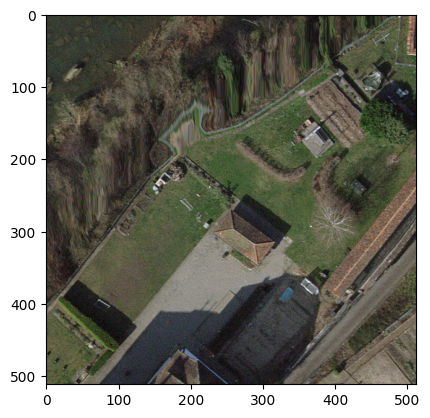

In [33]:
import matplotlib.pyplot as plt
 
plt.imshow(img)
# 
# # getting the image size
# height, width = img.shape[0], img.shape[1]
# 
# # creating the points for the lines in the range of the image size
# x_lines = np.arange(0, width, 1000)
# y_lines = np.arange(0, height, 1000)
# 
# # plotting vertical lines
# for xc in x_lines:
#     plt.axvline(x=xc, color='r', linestyle='--')
# 
# # plotting horizontal lines
# for yc in y_lines:
#     plt.hlines(yc, xmin=0, xmax=width, color='r', linestyle='--')
# 
# plt.show()

In [34]:
# ystart = 6000
# xstart = 9000
# xend = xstart + 512
# yend = ystart + 512

# plt.imshow(img[ystart:yend, xstart:xend, :])
# ipt = img[ystart:yend, xstart:xend, :]

In [35]:
ipt = img

# Overwrite the model configuration to use the specified stride and input resolution
config_mmcv["model"]["test_cfg"]["stride"] = (stride, stride)
config_mmcv["test_pipeline"][1]["img_scale"] = tuple(ipt.shape[0:2])

height, width, channels = ipt.shape
logger.info(f"Traitement de: {file_path_img} : shape h, w, c : {height}, {width}, {channels}")

# Perform inference on the image
result = inference_segmentor(model, ipt)

2024-03-11 16:11:35.286 | INFO     | __main__:<module>:8 - Traitement de: /proj-soils/data/scratch_test_rgb/200-2-2_scratch_20200319_1348_12501_0_41-42-43_aoi37.tif : shape h, w, c : 512, 512, 3


Processing patch 1/1


In [36]:
logits = result.cpu().numpy()
argmax = result.argmax(axis=1).cpu().numpy()
np.unique(argmax)

array([1, 2, 3, 5, 8, 9])

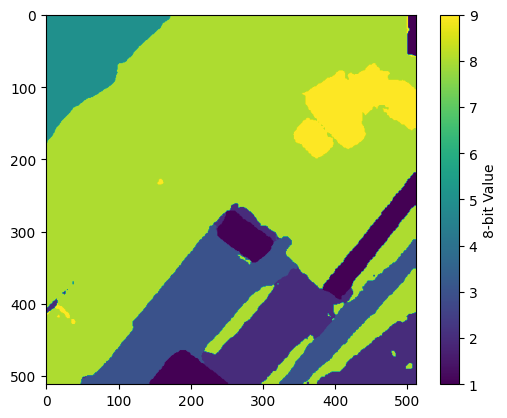

In [37]:
import matplotlib.pyplot as plt
im = plt.imshow(argmax[0])
# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('8-bit Value')

In [38]:
import torch.nn.functional as F

# Apply softmax
probabilities = F.softmax(torch.tensor(logits), dim=1)

# Normalize to [0,1], then scale to [0,255], and convert it to 8-bit integers
normalized_8bit = (probabilities * 255).byte()
normalized_8bit.shape

torch.Size([1, 12, 512, 512])

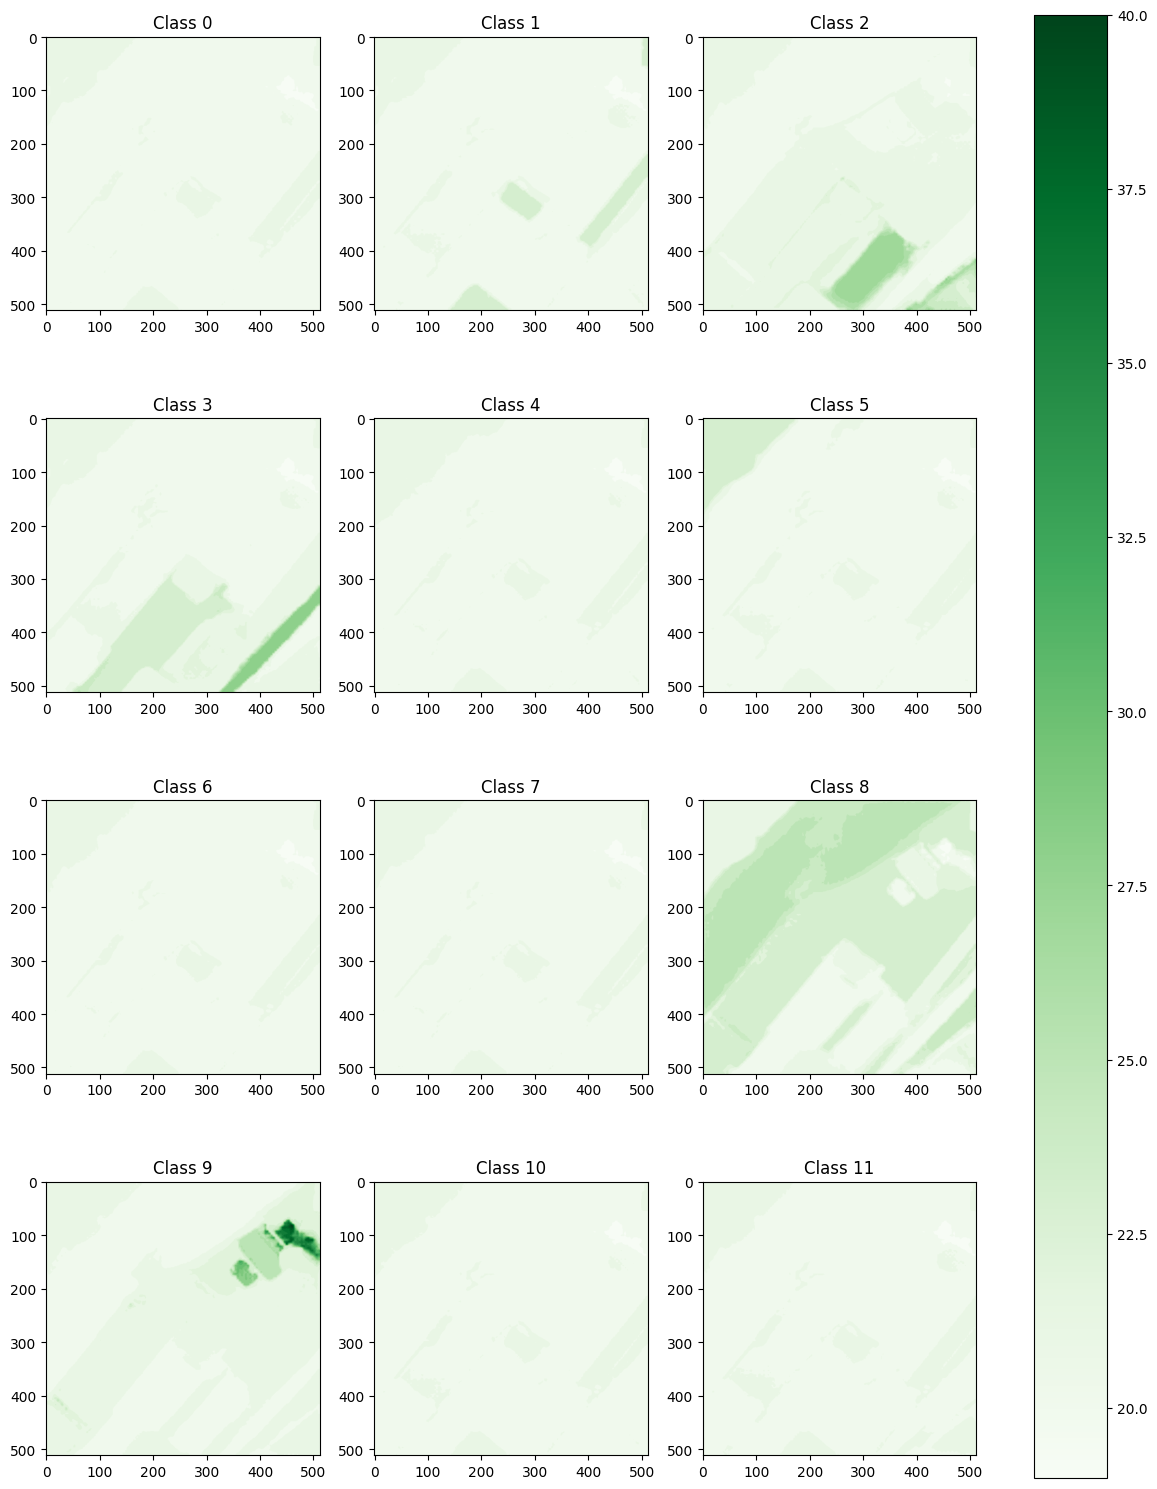

In [61]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows = 4, ncols=3, figsize=(15, 19))

# compute global min and max of the logits
vmin, vmax = np.min(normalized_8bit.numpy()), np.max(normalized_8bit.numpy())

idx = 0
for i in range(4):
    for j in range(3):
        im = axs[i, j].imshow(normalized_8bit[0, idx, :, :], cmap="Greens", vmin=vmin, vmax=vmax)
        axs[i, j].set_title(f"Class {idx}")
        idx += 1

cbar = plt.colorbar(im, ax=axs)

In [87]:
profile["count"] = 12

In [88]:
image_name = file_path_img.split(os.sep)[-1]
file_out_path = os.path.join(target_folder, image_name)

# Save the segmentation result as a new image
with rasterio.open(file_out_path, 'w', **profile) as dst:
    for i in range(12):
        dst.write(normalized_8bit[0, i].numpy().reshape((height, width)), i+1)